# Query URL reputation

## Introduction

- UUID: **432b6b97-6351-4c82-a497-80fa0d03af04**
- Started from [issue 14](https://github.com/MISP/misp-playbooks/issues/14)
- State: **Published** : demo version with **output**

This playbook functions similarly to the domain reputation playbook ([13](https://github.com/MISP/misp-playbooks/issues/13)). It analyses URLs by submitting them to **Lookyloo** and **URLscan**, while also querying OSINT feeds and MISP events for correlation. The playbook enriches the data with additional details, including DNS information, geolocation (**MMDB**), and historical scan data from URLscan and **VirusTotal**. All collected information is then consolidated into a summary, which is forwarded to Mattermost and TheHive for further action. This playbook is particularly valuable for managing **phishing security incidents**, equipping analysts with a comprehensive summary of URLs requiring investigation.

- Tags: [ "url", "reputation", "phishing" ]
- External resources: **URLscan**, **DNS**, **VirusTotal**, **MMDB**, **Mattermost, TheHive**
- Target audience: **SOC, CSIRT, CTI**

![](https://mermaid.ink/img/pako:eNqFU9Gq2zAM_RVj6EtpfyAPhY3C7oV2bLd3e1hduE6iNN5sq9hyRyj59zlO26S96xZIsKQjHR3FOvECS-AZn8_nwpIiDRlbP2--sIOWTY74i30N4Br27WXFHBwCSVJohU34yeSkrKKMnQSvNP4uaulI8GTXZPRK5qB956ik9tC2rJ1MhL1C2epFWBaf7itsf_Yh3zt5qNmzPYIntT8zdrHgNJvP-wa7jjD_CQVF14LBESxtUyQddzcZm5Ab1QNXUVSjEfv4xRpqPMqLfL6Q50bOxn0W2HIQNJJSoHOgR0JSzpA9ivvk9cEY6Zp7cAVQ_gfbdXDHDtapojb32p6UJ4wRqVmnxY9Vvi_cJy3Y8vNmG1-mbIXOpDZ2XbVPgBqLZCfcer38-KjK36m_Kxf8K5LUD2QNg738ncIBWF8j_WtoypaRKfI9Gm281-jGd4f1nt0t_jLVZHb0HzS4nuK1hid1hHvEgsUBETiDnm5ivTEEt4K_bTpii6QqdR4jIZtO11fQdPom-I7PuIm2VGXc2lNaHE41GOjWTPASKhl0XEJh2wiVgXDT2IJn5ALMuMOwr3mW1nHGw6GUBEsl4z0xV-9B2h-IF7v9A1g5W9k)

# Playbook

- **Query URL reputation**
    - Introduction
- **Preparation**
    - PR:1 Initialise environment
    - PR:2 Verify MISP modules
    - PR:3 Load helper functions
    - PR:4 Set helper variables
    - PR:5 What are you searching for?
    - PR:6 MISP event details
- **Investigate**
    - IN:1 Add the URL to the event
    - IN:2 Submit the URL to LookyLoo
    - IN:3 Submit the URL to URLscan
- **Correlation**
    - CR:1 Correlation with MISP events
    - CR:2 Correlation with MISP feeds
- **Enrichment**
    - ER:1 Enrich with historical information from URLscan
    - ER:2 Enrich with DNS information
    - ER:3 Enrich with historical results from VirusTotal
    - ER:4 Get geolocation of the IP from MMDB
- **Summary**
    - EN:1 Add screenshot from URLscan to playbook
    - EN:2 MISP indicators
    - EN:3 Create the summary of the playbook
    - EN:4 Add the summary as a MISP report
    - EN:5 Send a summary to Mattermost
    - EN:6 Send an alert to TheHive
    - EN:7 Publish MISP event
    - EN:8 End of the playbook
- External references
- Technical details

# Preparation

## PR:1 Initialise environment

This section **initialises the playbook environment** and loads the required Python libraries. 

The credentials for MISP (**API key**) and other services are loaded from the file `keys.py` in the directory **vault**. A [PyMISP](https://github.com/MISP/PyMISP) object is created to interact with MISP and the active MISP server is displayed. By printing out the server name you know that it's possible to connect to MISP. In case of a problem PyMISP will indicate the error with `PyMISPError: Unable to connect to MISP`.

The contents of the `keys.py` file should contain at least :

```
misp_url="<MISP URL>"                  # The URL to our MISP server
misp_key="<MISP API KEY>"              # The MISP API key
misp_verifycert=<True or False>        # Indicate if PyMISP should attempt to verify the certificate or ignore errors
urlscan_url="https://urlscan.io/api/v1/search"
urlscan_apikey="<URLSCAN API KEY>"
mattermost_playbook_user="<MATTERMOST USER>"
mattermost_hook="<MATTERMOST WEBHOOK>"
thehive_url="<THEHIVE URL>"
thehive_key="<THEHIVE API KEY>"
virustotal_apikey="<VIRUSTOTAL API KEY>"
```

In [36]:
# Initialise Python environment
import urllib3
import sys
import json
import base64
import uuid
import time
import re
from prettytable import PrettyTable, MARKDOWN
from IPython.display import Image, display, display_markdown, HTML
from datetime import date
import requests
from pymisp import *
from pymisp.tools import GenericObjectGenerator
import textwrap
import validators
from urllib.parse import urlparse
from pylookyloo import Lookyloo
from pyfaup.faup import Faup

# Load the credentials
sys.path.insert(0, "../vault/")
from keys import *
if misp_verifycert is False:
    import urllib3
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
print("The \033[92mPython libraries\033[90m are loaded and the \033[92mcredentials\033[90m are read from the keys file.")

# Create the PyMISP object
misp = PyMISP(misp_url, misp_key, misp_verifycert)
misp_headers = {"Authorization": misp_key,  "Content-Type": "application/json", "Accept": "application/json"}
print("I will use the MISP server \033[92m{}\033[90m for this playbook.\n\n".format(misp_url))

The version of PyMISP recommended by the MISP instance (2.4.198) is newer than the one you're using now (2.4.194). Please upgrade PyMISP.


The Python libraries are loaded and the credentials are read from the keys file.
I will use the MISP server https://misp.demo.cudeso.be/ for this playbook.




## PR:2 Verify MISP modules

This playbook uses the MISP modules to obtain additional correlation or enrichment information. [MISP modules](https://github.com/MISP/misp-modules) are autonomous modules that can be used to extend MISP for new services such as expansion, import and export. The modules are written in Python 3 following a simple API interface. The objective is to ease the extensions of MISP functionalities without modifying core components. The API is available via a simple REST API which is independent from MISP installation or configuration.

In the next cell we check if we have access to the **MISP module** server and if the required modules are enabled.

In [2]:
# Where can we find the local MISP Module server? You can leave this to the default setting in most cases.
misp_modules_url = "http://127.0.0.1:6666"

# How long do we wait between queries when using the MISP modules (API rate limiting of external service such as VirusTotal)
misp_modules_wait = 3

# Initiliasation
misp_modules = {}
misp_modules_headers = {
    "Content-Type": "application/json",
    "Accept": "application/json"
}
misp_modules_in_use = ["dns", "urlscan"]
# Code block to query the MISP module server and check if our modules are enabled
res = requests.get("{}/modules".format(misp_modules_url), headers=misp_modules_headers)
for module in res.json():
    for module_requested in misp_modules_in_use:
        if module.get("name", False) == module_requested:
            misp_modules[module_requested] = {"enabled": True, "input": module.get("mispattributes").get("input")}
            print("Found the \033[92m{}\033[90m MISP module (Accepted input: {}).".format(module_requested, misp_modules[module_requested]["input"]))
print("\n\n")

Found the dns MISP module (Accepted input: ['hostname', 'domain', 'domain|ip']).
Found the urlscan MISP module (Accepted input: ['hostname', 'domain', 'ip-src', 'ip-dst', 'url']).





## PR:3 Load helper functions

The next cell contains **helper functions** that are used in this playbook.

Instead of distributing helper functions as separate Python files this playbook includes all the required code as one code cell. This makes portability of playbooks between instances easier. The downside is that functions defined in this playbook need to be defined again in other playbooks, which is not optimal for code re-use. For this iteration of playbooks it is chosen to include the code in the playbook (more portability), but you can easily create one "helper" file that contains all the helper code and then import that file in each playbook (for example by adding to the previous cell `from helpers import *`).

In [3]:
def pb_get_misp_tags(tags=[], local_tags=[]):
    '''
    Get a list of MISP tags based on a Python list

    :param misp: MISP object
    :param object_template: which object template to return
    '''
    misp_tags = []
    for el in tags:
        t = MISPTag()
        t.name = el
        t.local = False
        misp_tags.append(t)

    for el in local_tags:
        t = MISPTag()
        t.name = el
        t.local = True
        misp_tags.append(t)
    return misp_tags

print("\033[92mHelper functions loaded\033[90m.\n\n".format(misp_url))

Helper functions loaded.




## PR:4 Set helper variables

This cell contains **helper variables** that are used in this playbook.

- `playbook_config` : the configuration of the playbook
- `playbook_results` : the results of the playbook

In [4]:
# Dictionary to playbook results and some of the core objects that are created
playbook_results = {}

playbook_config = {"event_title_default_prefix": "URL reputation investigation",
                   "event_tags": pb_get_misp_tags(["tlp:amber",
                                                   "misp-galaxy:mitre-attack-pattern=\"Domains - T1583.001\"",
                                                   "misp-galaxy:mitre-attack-pattern=\"Server - T1583.004\""],
                                                  ["workflow:state=\"incomplete\""]),
                   "attribute_tags": pb_get_misp_tags(["course-of-action:passive=\"discover\"",
                                                       "course-of-action:passive=\"detect\"",
                                                       "PAP:GREEN"],[]),
                   
                   "add_text_attributes": True,
                   
                   "correlation_published": True,
                   "correlation_limit": 1000,
                   "correlation_to_ids": True,
                   
                   "urlscan_size": 5,
                   "urlscan_replace": ["+", "-", "=", "&&", "||", ">", "<", "!", "(", ")", "{", "}", "[", "]", "^", "~", "*", "?", ":", "/"],
                   
                   "lookyloo_wait": 8,
                   "lookyloo_listing": True,
                   "lookyloo_tries": 10,
                   "lookyloo_process_hostnames": True,
                   "lookyloo_process_cookies": True,
                   "lookyloo_process_urls": True,
                   "lookyloo_process_hashes": True,
                   "lookyloo_hashtype": "md5",
                   "lookyloo_ids": 0,
                   
                   "mmdb_url": "https://ip.circl.lu/geolookup/",

                    }

# A set of regular expressions that we use to determine the attribute type
regular_expressions = {"sha256": "^[a-fA-F0-9]{64}$",
                       "md5": "^[a-fA-F0-9]{32}$",
                       "hostname": "^[a-zA-Z0-9.\-_]+\.[a-zA-Z]{2,}$",
                       "sha1": "^[a-fA-F0-9]{40}$",
                       "url": "^(http|https):\/\/[-a-zA-Z0-9-]{2,256}\.[-a-zA-Z0-9-]{2,256}",
                       "ip-src": "[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}",
                       "ip-dst": "[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}"
                      }

## PR:5 What are you searching for?

In this section you can define the **user input** as the **URL** that you want to investigate with this playbook.

In [5]:
# Provide the URL to investigate
query = "https://waterforvoiceless.org/invite.php" 

# Validate we have a valid URL to investigate
if validators.url(query):
    print("The playbook will continue with the investigation of \033[92m{}\033[90m \n\n".format(query))
    playbook_results["url"] = query
else:
    print("URL validation \033[91mfailed\033[90m.\nCheck that \033[91m{}\033[90m is a valid URL.\n\n".format(query))

The playbook will continue with the investigation of https://waterforvoiceless.org/invite.php 




## PR:6 MISP event details

The next cell **creates the MISP event** and adds the event tags.

In [6]:
# Provide the event title for a new event. Leave blank for the playbook to auto generate one
event_title = ""

# Create default event title
if not(event_title is str and len(event_title) > 0):
    event_title = "{} for {}".format(playbook_config["event_title_default_prefix"], playbook_results["url"])

# Create the PyMISP object for an event
event = MISPEvent()
event.info = event_title
event.distribution = Distribution.your_organisation_only
event.threat_level_id = ThreatLevel.low
event.analysis = Analysis.ongoing
event.set_date(date.today())

# Create the MISP event
misp_event = misp.add_event(event, pythonify=True)
print("Create MISP event")
playbook_results["event"] = misp_event.uuid

for tag in playbook_config["event_tags"]:
    misp.tag(misp_event.uuid, tag, local=tag.local)
    print(" \033[92mAdded\033[90m event tag {}".format(tag))

print("Continue the playbook with the new MISP event ID \033[92m{}\033[90m with title \033[92m{}\033[90m and UUID \033[92m{}\033[90m.\n\n".format(misp_event.id, misp_event.info, misp_event.uuid))

Create MISP event
 Added event tag <MISPTag(name=tlp:amber)>
 Added event tag <MISPTag(name=misp-galaxy:mitre-attack-pattern="Domains - T1583.001")>
 Added event tag <MISPTag(name=misp-galaxy:mitre-attack-pattern="Server - T1583.004")>
 Added event tag <MISPTag(name=workflow:state="incomplete")>
Continue the playbook with the new MISP event ID 3567 with title URL reputation investigation for https://waterforvoiceless.org/invite.php and UUID 171b36d9-7a78-44a8-aa16-c7ff65f74b62.




# Investigate

## IN:1 Add the URL to the event

As a first step we add the URL as an `url` MISP object to our event.

In [7]:
# Add the URL as an object to the event
fp = Faup()
fp.decode(playbook_results["url"])
parsed = fp.get()

attributes = [
    ("url", "url", query, playbook_config["attribute_tags"]),
    ("tld", "text", parsed["tld"], None),
    ("subdomain", "text", parsed["subdomain"], None),
    ("scheme", "text", parsed["scheme"], None),
    ("resource_path", "text", parsed["resource_path"], None),
    ("query_string", "text", parsed["query_string"], None),
    ("port", "port", parsed["port"], None),
    ("host", "hostname", parsed["host"], None),
    ("fragment", "text", parsed["fragment"], None),
    ("domain_without_tld", "text", parsed["domain_without_tld"], None),
    ("domain", "domain", parsed["domain"], playbook_config["attribute_tags"]),
]

obj = MISPObject("url")
for attr_name, attr_type, value, tags in attributes:
    if value is not None:  # Add only if the value is not None
        obj.add_attribute(attr_name, type=attr_type, value=value, tags=tags)
        playbook_results[attr_name] = value
result = misp.add_object(misp_event.uuid, obj, pythonify=True)
if not "errors" in result:
    playbook_results["url_object"] = result
    print("\033[92mAdded\033[90m URL object for {} with UUID \033[92m{}\033[90m.\n\n".format(playbook_results["url"], result.uuid))
    # Get the URL attribute ID
    for attribute in playbook_results["url_object"].attributes :
        if attribute.object_relation == "url":
            playbook_results["url_attribute"] = attribute.uuid
else:
    print("\033[91mUnable to add URL object\033[90m for {}. The playbook \033[91mcannot continue\033[90m.\n\n".format(playbook_results["url"]))

Added URL object for https://waterforvoiceless.org/invite.php with UUID c4448955-de66-4b23-945c-fb07ed5eb2a4.




## IN:2 Submit the URL to LookyLoo

You can now submit the URL to **LookyLoo** for analysis.

[Lookyloo](https://github.com/Lookyloo/lookyloo) is a web interface that allows users to capture a website page and then display a tree of domains that call each other. You can explore its features with the demo instance at [https://lookyloo.circl.lu/](https://lookyloo.circl.lu/). If you use a public instance of LookyLoo it is advised not to display the capture on the index page of that LookyLoo instance (`playbook_config["lookyloo_listing"]`). The playbook waits for the LookyLoo capture to complete.

The process is split in two cells, first **submit** the URL, and the second step checks if the **analysis is finished**.

In [8]:
# Submit the URL to LookyLoo
lookyloo = Lookyloo(lookyloo_url)

playbook_results["lookyloo"] = {}

print("Submit URL to LookyLoo")
try:
    permaurl = lookyloo.submit(url=playbook_results["url"], listing=playbook_config["lookyloo_listing"])
    uuid = permaurl.split("/tree/")[1]
    print(" URL \033[92m{}\033[90m submitted to Lookyloo: {}\n".format(playbook_results["url"], permaurl))
    misp_attribute = {"type": "link", "category": "External analysis", 
                      "value": permaurl, "comment": "LookyLoo analysis for {}".format(playbook_results["url"])}
    created_attribute = misp.add_attribute(misp_event.uuid, misp_attribute, pythonify=True)
    if not "errors" in created_attribute:
        misp.add_object_reference(playbook_results["url_object"].add_reference(created_attribute.uuid, "related-to"))
        playbook_results["lookyloo"]["permaurl"] = permaurl
        print(" Reference to external LookyLoo analysis added.\n\n")
except:
    print("Was unable to submit the URL to LookyLoo.\n\n")

Submit URL to LookyLoo
 URL https://waterforvoiceless.org/invite.php submitted to Lookyloo: https://lookyloo.circl.lu/tree/a8eb8772-0230-4d8d-916b-5cab555df1b5

 Reference to external LookyLoo analysis added.




In [9]:
# Query the results of LookyLoo to get the capture details
submit_completed = False
print("Contact LookyLoo ...")
playbook_config["lookyloo_tries"] = 10
while playbook_config["lookyloo_tries"] >= 0:
    print(" Checking if submission of {} is complete".format(uuid))
    status_code = int(lookyloo.get_status(uuid).get("status_code", 0))
    if status_code == 1:
        submit_completed = True
        playbook_config["lookyloo_tries"] = -1
    else:
        print("  Attempting again after {} seconds".format(playbook_config["lookyloo_wait"]))
        time.sleep(playbook_config["lookyloo_wait"])
        playbook_config["lookyloo_tries"] -= 1
if submit_completed:
    print("Got \033[92mresults\033[90m, continue with the next cell.\n\n")
else:
    print("Submit was \033[91mnot completed\033[90m after {} verification attempts. Re-execute this cell to try again.\n\n".format(playbook_config["lookyloo_tries"]))

Contact LookyLoo ...
 Checking if submission of a8eb8772-0230-4d8d-916b-5cab555df1b5 is complete
  Attempting again after 8 seconds
 Checking if submission of a8eb8772-0230-4d8d-916b-5cab555df1b5 is complete
  Attempting again after 8 seconds
 Checking if submission of a8eb8772-0230-4d8d-916b-5cab555df1b5 is complete
  Attempting again after 8 seconds
 Checking if submission of a8eb8772-0230-4d8d-916b-5cab555df1b5 is complete
  Attempting again after 8 seconds
 Checking if submission of a8eb8772-0230-4d8d-916b-5cab555df1b5 is complete
  Attempting again after 8 seconds
 Checking if submission of a8eb8772-0230-4d8d-916b-5cab555df1b5 is complete
Got results, continue with the next cell.




### Process LookyLoo results

When the results are received from **LookyLoo**, they must be processed to ensure they can be incorporated into the **MISP event**, the **summary**, and this **playbook**. The playbook processes associated hostnames (by default the to_ids flag is not set, this can be configured via `playbook_config["lookyloo_hostname_ids"]`) and obtained cookies.

In [10]:
# Get the results from LookyLoo
from datetime import datetime, timezone
playbook_results["lookyloo"]["hostnames"] = []
playbook_results["lookyloo"]["cookies"] = [] 
playbook_results["lookyloo"]["hashes"] = [] 
playbook_results["lookyloo"]["urls"] = [] 

print("Processing LookyLoo results")
if playbook_config["lookyloo_process_hostnames"]:
    print(" Process hostnames")
    lookyloo_hostnames = lookyloo.get_hostnames(uuid)
    if lookyloo_hostnames.get("message", "") == "Internal Server Error":
        lookyloo_hostnames = []
    for hostname in lookyloo_hostnames.get("response", {}).get("hostnames", []):
        if hostname not in playbook_results["lookyloo"]["hostnames"]:
            misp_attribute = {"to_ids": playbook_config["lookyloo_ids"], "type": "hostname", "category": "Network activity", 
                          "value": hostname, "comment": "LookyLoo associated hostname for {}".format(playbook_results["url"])}
            created_attribute = misp.add_attribute(misp_event.uuid, misp_attribute, pythonify=True)
            if not "errors" in created_attribute:
                misp.add_object_reference(playbook_results["url_object"].add_reference(created_attribute.uuid, "related-to"))
                playbook_results["lookyloo"]["hostnames"].append(hostname)
                print(" Found hostname: \033[92m{}\033[90m".format(hostname))

if playbook_config["lookyloo_process_urls"]:
    print(" Process URLs")
    lookyloo_urls = lookyloo.get_urls(uuid)
    if lookyloo_urls.get("message", "") == "Internal Server Error":
        lookyloo_urls = []
    for url_value in lookyloo_urls.get("response", {}).get("urls", []):
        misp_attribute = {"to_ids": playbook_config["lookyloo_ids"], "type": "url", "category": "Network activity", 
                      "value": url_value, "comment": "LookyLoo associated URL for {}".format(playbook_results["url"])}
        created_attribute = misp.add_attribute(misp_event.uuid, misp_attribute, pythonify=True)
        if not "errors" in created_attribute:
            misp.add_object_reference(playbook_results["url_object"].add_reference(created_attribute.uuid, "related-to"))
            playbook_results["lookyloo"]["urls"].append(url_value)
            print(" Found URL: \033[92m{}\033[90m".format(url_value))

if playbook_config["lookyloo_process_hashes"]:
    print(" Process hashes")
    lookyloo_hashes = lookyloo.get_hashes(uuid, playbook_config["lookyloo_hashtype"])
    if lookyloo_hashes.get("message", "") == "Internal Server Error":
        lookyloo_hashes = []
    for hash_value in lookyloo_hashes.get("response", {}).get("hashes", []):
        misp_attribute = {"to_ids": playbook_config["lookyloo_ids"], "type": playbook_config["lookyloo_hashtype"], "category": "Payload delivery", 
                      "value": hash_value, "comment": "LookyLoo associated hash for {}".format(playbook_results["url"])}
        created_attribute = misp.add_attribute(misp_event.uuid, misp_attribute, pythonify=True)
        if not "errors" in created_attribute:
            misp.add_object_reference(playbook_results["url_object"].add_reference(created_attribute.uuid, "related-to"))
            playbook_results["lookyloo"]["hashes"].append(hash_value)
            print(" Found hash: \033[92m{}\033[90m".format(hash_value))
        
if playbook_config["lookyloo_process_cookies"]:
    print(" Process cookies")
    lookyloo_cookies = lookyloo.get_cookies(uuid)
    if not isinstance(lookyloo_cookies, list) and lookyloo_cookies.get("message", "") == "Internal Server Error":
        lookyloo_cookies = []
    for cookie in lookyloo_cookies:
        obj = MISPObject("cookie")
        iso_8601_format = datetime.fromtimestamp(cookie["expires"]).isoformat()
        cookie_attribute = "; ".join(f"{key}={value}" for key, value in cookie.items())

        cookie_attributes = [
            ("cookie", "text", cookie_attribute),
            ("cookie-name", "text", cookie["name"]),
            ("cookie-value", "text", cookie["value"]),
            ("text", "text", cookie["domain"]),
            ("path", "text", cookie["path"]),
            ("expires", "datetime", iso_8601_format),
            ("http-only", "boolean", cookie["httpOnly"]),
            ("secure", "boolean", cookie["secure"]),
        ]
        for attr_name, attr_type, value in cookie_attributes:
            if value is not None:  # Add only if the value is not None
                obj.add_attribute(attr_name, type=attr_type, value=value)
                playbook_results[attr_name] = value
        cookie_object = misp.add_object(misp_event.uuid, obj, pythonify=True)
        if not "errors" in result:
            print(" Found cookie {}".format(cookie_attribute))
            misp.add_object_reference(playbook_results["url_object"].add_reference(cookie_object.uuid, "linked-to"))
            playbook_results["lookyloo"]["cookies"].append({"name": cookie["name"], 
                                                         "value": cookie["value"], 
                                                         "domain": cookie["domain"], 
                                                         "path": cookie["path"],
                                                         "cookie": cookie_attribute})
# Not processed:
# lookyloo.get_url_occurrences(playbook_results["url"])
# lookyloo.get_comparables(uuid)
# lookyloo.get_hostname_occurrences(playbook_results["domain"], 1, 20)
print("Finished processing LookyLoo results.\n\n")

Processing LookyLoo results
 Process hostnames
 Found hostname: unpkg.com
 Found hostname: waterforvoiceless.org
 Found hostname: fonts.googleapis.com
 Found hostname: fonts.gstatic.com
 Found hostname: cdnjs.cloudflare.com
 Process URLs
 Found URL: https://waterforvoiceless.org/wp-content/uploads/2022/10/youtube.png
 Found URL: https://waterforvoiceless.org/wp-includes/js/jquery/jquery-migrate.min.js?ver=3.4.1
 Found URL: https://waterforvoiceless.org/wp-content/plugins/contact-form-7/includes/js/index.js?ver=5.8.5
 Found URL: https://unpkg.com/splitting@1.1.0/dist/splitting.min.js
 Found URL: blob:https://waterforvoiceless.org/3b03c643-cc16-4f1c-9fd0-7c36d6807a81
 Found URL: https://waterforvoiceless.org/wp-content/plugins/contact-form-7/includes/css/styles.css?ver=5.8.5
 Found URL: https://fonts.gstatic.com/s/arimo/v29/P5sMzZCDf9_T_10ZxCE.woff2
 Found URL: https://waterforvoiceless.org/wp-content/uploads/2022/10/facbook.png
 Found URL: https://waterforvoiceless.org/wp-content/themes

### LookyLoo submit results

The results are now stored in `playbook_results`. Execute the next cell to display them in a table format.

In [11]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Type", "Name"]
table.align["Value"] = "l"
table.align["Category"] = "l"
table.align["Type"] = "l"
table.align["Name"] = "l"
table._max_width = {"Name": 50}

module_name = "lookyloo"
submodule_name = "hostnames"
for match in playbook_results[module_name][submodule_name]:
    table.add_row([submodule_name, playbook_results["url"], match, "hostname"])
submodule_name = "cookies"
for match in playbook_results[module_name][submodule_name]:
    table.add_row([submodule_name, playbook_results["url"], match["cookie"], match["name"]])
submodule_name = "urls"
for match in playbook_results[module_name][submodule_name]:
    table.add_row([submodule_name, playbook_results["url"], match, "URL"])
submodule_name = "hashes"
for match in playbook_results[module_name][submodule_name]:
    table.add_row([submodule_name, playbook_results["url"], match, playbook_config["lookyloo_hashtype"]])
print(table.get_string(sortby="Value"))
table_lookyloo = table

+-----------+------------------------------------------+--------------------------------------------------------------------------------------------------------------------+----------+
|   Source  | Value                                    | Type                                                                                                               | Name     |
+-----------+------------------------------------------+--------------------------------------------------------------------------------------------------------------------+----------+
|   hashes  | https://waterforvoiceless.org/invite.php | 0c5381a08e5e991f5170445fe9096d0d                                                                                   | md5      |
|   hashes  | https://waterforvoiceless.org/invite.php | 1bf058ff376600c29077b71fc0f44383                                                                                   | md5      |
|   hashes  | https://waterforvoiceless.org/invite.php | 23d5b23255c78fff1d

## IN:3 Submit the URL to URLscan

This section **submits** the URL to [URLscan.io](https://urlscan.io/) for scanning. It does this via the MISP module. Take care the URL does not contain sensitive or confidential information.

In [12]:
# Submit the URL to URLscan
module_name = "urlscan"
check_screenshot = "/screenshots/"
check_result = "/result/"
playbook_results[module_name] = {}

if misp_modules[module_name]["enabled"] and len(query) > 0:
    data = {
        "url": playbook_results["url"],
        "config": {"apikey": urlscan_apikey},
        "module": module_name
    }
    print("Submit \033[92m{}\033[90m to \033[92m{}\033[90m".format(playbook_results["url"], module_name))
    result = requests.post("{}/query".format(misp_modules_url), headers=misp_modules_headers, json=data)
    if "error" in result.json():
        print("Error: \033[91m{}\033[90m".format(result.json()["error"]))
    else:
        if "results" in result.json() and len(result.json()["results"]) > 0:
            result_json = result.json()["results"]
            for attribute in result_json:
                misp_attribute = {"type": attribute["types"], "category": attribute["categories"][0], 
                                  "value": attribute["values"], "comment": attribute["comment"]}
                created_attribute = misp.add_attribute(misp_event.uuid, misp_attribute, pythonify=True)
                if not "errors" in created_attribute:
                    misp.add_object_reference(playbook_results["url_object"].add_reference(created_attribute.uuid, "related-to"))
                    urlscan_type = False
                    if misp_attribute["type"] == "text":
                        urlscan_type = "text"
                        # Do we already have 'new' comment style for this module?
                        if " - " in misp_attribute["comment"]:
                            urlscan_type = misp_attribute["comment"].split(" - ")[1]
                    else:
                        urlscan_type = misp_attribute["type"]
                    if urlscan_type:
                        if playbook_results[module_name].get(urlscan_type):
                            playbook_results[module_name][urlscan_type].append(misp_attribute["value"])
                        else:
                            playbook_results[module_name][urlscan_type] = [misp_attribute["value"]]
                    print(" Got {} \033[92m{}\033[90m".format(misp_attribute["type"], misp_attribute["value"]))
                    if check_result in misp_attribute["value"]:
                        playbook_results["urlscan_resultlink"] = misp_attribute["value"]
                    #if urlscan_type == "Country/City":
                    #    playbook_results[module_name]["geolocation"] = misp_attribute["value"]
                    if check_screenshot in misp_attribute["value"]:
                        screenshot_data = requests.get(misp_attribute["value"])
                        b_screenshot_data = base64.b64encode(screenshot_data.content).decode('utf-8')
                        playbook_results["screenshot"] = b_screenshot_data
                        attribute = MISPAttribute()
                        attribute.value = "screenshot-{}-{}".format(playbook_results["url"], misp_attribute["value"].split("screenshots/")[1])
                        attribute.to_ids = False
                        attribute.type = "attachment"
                        attribute.disable_correlation = True
                        attribute.comment = "Screenshot for {}".format(playbook_results["url"])
                        attribute.data = b_screenshot_data
                        attribute_screenshot = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)
                        if not "errors" in attribute_screenshot:
                            misp.add_object_reference(playbook_results["url_object"].add_reference(attribute_screenshot.uuid, "screenshot-of"))
                            print(" Got \033[92mscreenshot\033[90m")
    
print("Finished {}.\n\n".format(module_name))

Submit https://waterforvoiceless.org/invite.php to urlscan
 Got domain waterforvoiceless.org
 Got ip-dst 162.241.169.194
 Got hostname 162-241-169-194.unifiedlayer.com
 Got text country: US
 Got AS AS46606
 Got text UNIFIEDLAYER-AS-1, US
 Got text R11
 Got text Page not found – Water for Voiceless


Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}


 Got text nginx/1.25.5
 Got link https://urlscan.io/result/0e199b24-36af-4884-854c-26c0373d73b6/
 Got link https://urlscan.io/screenshots/0e199b24-36af-4884-854c-26c0373d73b6.png
 Got screenshot
Finished urlscan.




### URLscan submit results

The results are now stored in `playbook_results`. Execute the next cell to display them in a table format.

In [13]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Type", "Enriched"]
table.align["Value"] = "l"
table.align["Category"] = "l"
table.align["Type"] = "l"
table.align["Enriched"] = "l"
table._max_width = {"Enriched": 50}
for match in playbook_results[module_name]:
    table.add_row([module_name, playbook_results["url"], match, "\n".join(playbook_results[module_name][match])])
print(table.get_string(sortby="Value"))
table_urlscan = table

+---------+------------------------------------------+--------------+----------------------------------------------------+
|  Source | Value                                    | Type         | Enriched                                           |
+---------+------------------------------------------+--------------+----------------------------------------------------+
| urlscan | https://waterforvoiceless.org/invite.php | AS           | AS46606                                            |
| urlscan | https://waterforvoiceless.org/invite.php | ASN name     | UNIFIEDLAYER-AS-1, US                              |
| urlscan | https://waterforvoiceless.org/invite.php | Country/City | country: US                                        |
| urlscan | https://waterforvoiceless.org/invite.php | Page title   | Page not found – Water for Voiceless               |
| urlscan | https://waterforvoiceless.org/invite.php | Server       | nginx/1.25.5                                       |
| urlscan | http

# Correlation

## CR:1 Correlation with MISP events

This cell searches the **MISP server** for events that have a match with the URL. A summary of the correlation is also shown at the end of the playbook.

Only **published** events (`playbook_config["correlation_published"]`) and attributes that have the **to_ids** flag (`playbook_config["correlation_to_ids"]`) set are taken into account. There is a default limit of **1000 hits** (`playbook_config["correlation_limit"]`).

In [14]:
# Query MISP and find the correlations
print("Search in MISP events.")
search_value = [playbook_results["url"], playbook_results["domain"], playbook_results["host"]]
playbook_results["related_events"] = []
match = False

for value in search_value:
    search_match = misp.search("events", value=value, published=playbook_config["correlation_published"],
                                        limit=playbook_config["correlation_limit"], pythonify=True)
    for event in search_match:
        if event.uuid != playbook_results["event"]:   # Skip the event we just created for this playbook
            entry = {"source": "MISP", "org": event.org.name, "event_id": event.id, 
                                 "event_info": event.info, "date": event.date,
                                 "value": value}
            if entry not in playbook_results["related_events"]:
                match = True
                print(" Found match for \033[92m{}\033[90m in \033[92m{}\033[90m".format(value, event.id, event.info))
                playbook_results["related_events"].append(entry)
if not match:  
    print("\033[93mNo correlating MISP events\033[90m found for {}.".format(playbook_results["url"]))
print("Finished correlating with MISP events.\n\n")

Search in MISP events.
 Found match for https://waterforvoiceless.org/invite.php in 3450
 Found match for waterforvoiceless.org in 3450
Finished correlating with MISP events.




### MISP events correlation table

The correlation results are now stored in `playbook_results`. Execute the next cell to display them in a table format.

In [15]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Event", "Event ID"]
table.align["Value"] = "l"
table.align["Event"] = "l"
table.align["Event ID"] = "l"
table._max_width = {"Event": 50}
for match in playbook_results["related_events"]:
    table.add_row([match["source"], match["value"], match["event_info"], match["event_id"]])
print(table.get_string(sortby="Value"))
table_mispevents = table

+--------+------------------------------------------+----------------------------------------------------+----------+
| Source | Value                                    | Event                                              | Event ID |
+--------+------------------------------------------+----------------------------------------------------+----------+
|  MISP  | https://waterforvoiceless.org/invite.php | APT29 Uses WINELOADER to Target German Political   | 3450     |
|        |                                          | Parties                                            |          |
|  MISP  | waterforvoiceless.org                    | APT29 Uses WINELOADER to Target German Political   | 3450     |
|        |                                          | Parties                                            |          |
+--------+------------------------------------------+----------------------------------------------------+----------+


## CR:2 Correlation with MISP feeds

Search the MISP feeds for events that match with the URL. The results depend on the feeds you have enabled on your MISP server. 

In [16]:
# Query MISP feeds and find the correlations
print("Search in MISP feeds.")
misp_cache_url = "{}/feeds/searchCaches/".format(misp_url)
search_value = [playbook_results["url"], playbook_results["domain"], playbook_results["host"]]
playbook_results["related_feeds"] = []    
match = False

# Instead of GET, use POST (https://github.com/MISP/MISP/issues/7478)
for value in search_value:
    cache_results = requests.post(misp_cache_url, headers=misp_headers, verify=misp_verifycert, json={"value": value})
    for result in cache_results.json():
        if "Feed" in result:
            match = True
            for match in result["Feed"]["direct_urls"]:
                entry = {"source": "Feeds", "value": value, "feed_name": result["Feed"]["name"], "match_url": match["url"]}
                if entry not in playbook_results["related_feeds"]:
                    print(" Match \033[92m{}\033[90m in \033[92m{}\033[90m.".format(value, result["Feed"]["name"]))
                    playbook_results["related_feeds"].append(entry)
if not match:
    print("\033[93mNo correlating information\033[90m found in MISP feeds.")
print("Finished searching in MISP feeds.")

Search in MISP feeds.
 Match https://waterforvoiceless.org/invite.php in The Botvrij.eu Data.
 Match https://waterforvoiceless.org/invite.php in The Botvrij.eu Data.
 Match waterforvoiceless.org in The Botvrij.eu Data.
Finished searching in MISP feeds.


### MISP feed correlations table

The correlation results are now stored in `playbook_results`. Execute the next cell to display them in a table format.

In [17]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Feed", "Feed URL"]
table.align["Value"] = "l"
table.align["Feed"] = "l"
table.align["Feed URL"] = "l"
table._max_width = {"Event": 50}

for match in playbook_results["related_feeds"]:
    table.add_row([match["source"], match["value"], match["feed_name"], match["match_url"]])
print(table.get_string(sortby="Value"))
table_mispfeeds = table

+--------+------------------------------------------+---------------------+---------------------------------------------------------------------------------------+
| Source | Value                                    | Feed                | Feed URL                                                                              |
+--------+------------------------------------------+---------------------+---------------------------------------------------------------------------------------+
| Feeds  | https://waterforvoiceless.org/invite.php | The Botvrij.eu Data | https://misp.demo.cudeso.be/feeds/previewEvent/2/9ceb0659-15fc-4732-a8ef-bfcfebd1f068 |
| Feeds  | https://waterforvoiceless.org/invite.php | The Botvrij.eu Data | https://misp.demo.cudeso.be/feeds/previewEvent/2/cc498a46-ea03-4bb4-8212-e92402b7aaf3 |
| Feeds  | waterforvoiceless.org                    | The Botvrij.eu Data | https://misp.demo.cudeso.be/feeds/previewEvent/2/cc498a46-ea03-4bb4-8212-e92402b7aaf3 |
+--------+------

# Enrichment

## ER:1 Enrich with historical information from URLscan

This section queries [URLscan.io](https://urlscan.io/) for historical scan results of the **URL**.

Note that attributes already obtained previously by submitting the URL to URLscan cannot be added again (MISP does not accept multiple attributes of the same category, type and value).

In [18]:
# Search historical scans in URLscan
module_name = "urlscan-history"
playbook_results[module_name] = {}
enrichment = []
print("Search in \033[92m{}\033[90m.".format(module_name))

url = playbook_results["url"]
for k in playbook_config["urlscan_replace"]:
    url = url.replace(k, "\{}".format(k))      # Required by URLscan to avoid errors in the submit

headers = {"API-Key": urlscan_apikey, "Content-Type": "application/json", "Cache-Control": "no-cache"}
result = requests.get("{}/?size={}&q=page.url:{}".format(urlscan_url, playbook_config["urlscan_size"], url), headers=headers)
if result.status_code == 200 and result.json().get("total") > 0:
    print(" Received URLscan results for \033[92m{}\033[90m".format(playbook_results["url"]))
    for el in result.json().get("results"):
        screenshot_data = requests.get(el["screenshot"])
        enrichment.append({
                "url": el["page"]["url"],
                "ip": el["page"].get("ip", False),
                "ptr": el["page"].get("ptr", False),
                "server": el["page"].get("server", "Unknown").strip(),
                "title": el["page"].get("title", "").strip(),
                "result": el["result"],
                "tlsIssuer": el["page"].get("tlsIssuer", False),
                "screenshot": el["screenshot"],
                "screenshot_data": screenshot_data
        })
print("Finished querying {} for enrichment.".format(module_name))

# Extract enriched elemnts
print("Processing enrichment of {}".format(module_name))
urlscan_attribute_map = {
        "ip": {"type": "ip-dst", "category": "Network activity", "comment": ""},
        "server": {"type": "text", "category": "External analysis", "comment": " - Server"},
        "title": {"type": "text", "category": "External analysis", "comment": " - Page title"},
        "ptr": {"type": "hostname", "category": "Network activity", "comment": ""},
        "tlsIssuer": {"type": "text", "category": "External analysis", "comment": " - TLS Issuer"},
    }
for enriched in enrichment:
    for key, attribute_info in urlscan_attribute_map.items():
        if key in enriched:
            misp_attribute = {
                "type": attribute_info["type"],
                "category": attribute_info["category"],
                "value": enriched[key],
                "comment": "{}: Historical scan from urlscan".format(playbook_results["url"]) + attribute_info["comment"]
            }
            created_attribute = misp.add_attribute(misp_event.uuid, misp_attribute, pythonify=True)
            if "errors" not in created_attribute:
                print(" Got \033[92m{}\033[90m".format(enriched[key]))
                misp.add_object_reference(playbook_results["url_object"].add_reference(created_attribute.uuid, "related-to"))
                urlscan_type = False
                if misp_attribute["type"] == "text":
                    urlscan_type = "text"
                    # Do we already have 'new' comment style for this module?
                    if " - " in misp_attribute["comment"]:
                        urlscan_type = misp_attribute["comment"].split(" - ")[1]
                else:
                    urlscan_type = misp_attribute["type"]
                if urlscan_type:
                    if playbook_results[module_name].get(attribute_info["type"]):
                        playbook_results[module_name][urlscan_type].append(misp_attribute["value"])
                    else:
                        playbook_results[module_name][urlscan_type] = [misp_attribute["value"]]
                            
    if "screenshot" in enriched:
        b_screenshot_data = base64.b64encode(enriched["screenshot_data"].content).decode('utf-8')
        attribute = MISPAttribute()
        attribute.value = "screenshot-{}-{}".format(playbook_results["url"], enriched["screenshot"].split("screenshots/")[1])
        attribute.to_ids = False
        attribute.type = "attachment"
        attribute.disable_correlation = True
        screenshot_time = enriched.get("time", "")
        attribute.comment = "Screenshot of historical scan {} for {}".format(screenshot_time, playbook_results["url"])
        attribute.data = b_screenshot_data
        attribute_screenshot = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)                    
        if not "errors" in attribute_screenshot:
            misp.add_object_reference(playbook_results["url_object"].add_reference(attribute_screenshot.uuid, "screenshot-of"))
            print(" Got \033[92mscreenshot\033[90m")
print("Finished procesing {} enrichment results.\n\n".format(module_name))

Search in urlscan-history.
 Received URLscan results for https://waterforvoiceless.org/invite.php


Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}


Finished querying urlscan-history for enrichment.
Processing enrichment of urlscan-history


Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute'

 Got screenshot


Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}


 Got screenshot


Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute'

 Got screenshot


Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}
Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}


 Got screenshot
Finished procesing urlscan-history enrichment results.




### Historical URLscan results

The results are now stored in `playbook_results`. Execute the next cell to display them in a table format.

In [19]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Type", "Enriched"]
table.align["Value"] = "l"
table.align["Category"] = "l"
table.align["Type"] = "l"
table.align["Enriched"] = "l"
table._max_width = {"Enriched": 50}
for match in playbook_results[module_name]:
    table.add_row([module_name, playbook_results["url"], match, "\n".join(playbook_results[module_name][match])])
print(table.get_string(sortby="Value"))
table_urlscan_history = table

+--------+-------+------+----------+
| Source | Value | Type | Enriched |
+--------+-------+------+----------+
+--------+-------+------+----------+


## ER:2 Enrich with DNS information

The next cell queries the MISP DNS module and add the DNS resolution as a MISP `domain-ip` object. This new object is linked to the URL via a relation `resolves-to`.

This module uses the default DNS resolver defined in the MISP module (8.8.8.8) but you can also specify your own DNS server with `module_dnsserver`.

In [20]:
# DNS server to use. Leave blank to use 8.8.8.8 (default MISP module)
module_dnsserver = ""

module_name = "dns"
module_comment = f"From {module_name}"
playbook_results[module_name] = {}

print("Start \033[92m{}\033[90m.".format(module_name))
if misp_modules[module_name]["enabled"] and len(query) > 0:
    domain = urlparse(playbook_results["url"]).netloc
    attribute_type = "domain"
    data = {
        "domain": f"{domain}",
        "module": module_name
    }
    if len(module_dnsserver) > 0:
        data["config"] = { "nameserver": module_dnsserver }
    print("Query \033[92m{}\033[90m".format(playbook_results["url"]))
    result = requests.post("{}/query".format(misp_modules_url), headers=misp_modules_headers, json=data)
    result_dns = result
    if "results" in result.json() and len(result.json()["results"]) > 0:
        result_json = result.json()["results"]
        for entry in result_json:
            if "values" in entry:
                playbook_results[module_name]["resolves"] = []
                for module_value in entry["values"]:
                    ip_object = MISPObject("domain-ip")
                    ip_object.add_attribute("ip", module_value, comment=module_comment)
                    ip_object_misp = misp.add_object(misp_event.uuid, ip_object, pythonify=True)
                    if not "errors" in ip_object_misp:
                        misp.add_object_reference(playbook_results["url_object"].add_reference(ip_object_misp.uuid, "resolves-to"))
                        print(" Got \033[92m{}\033[90m".format(module_value))
                        if module_value not in playbook_results[module_name]["resolves"]:
                            playbook_results[module_name]["resolves"].append(module_value)

print("Finished DNS enrichment.\n\n")

Start dns.
Query https://waterforvoiceless.org/invite.php
 Got 162.241.169.194
Finished DNS enrichment.




### DNS enrichment table

The results are now stored in `playbook_results`. Execute the next cell to display them in a table format.

In [21]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Type", "Enriched"]
table.align["Value"] = "l"
table.align["Category"] = "l"
table.align["Type"] = "l"
table.align["Enriched"] = "l"
table._max_width = {"Enriched": 50}
for match in playbook_results[module_name]:
    for resolve in playbook_results[module_name]["resolves"]:
        table.add_row([module_name, playbook_results["url"], match, resolve])
print(table.get_string(sortby="Value"))
table_dns = table

+--------+------------------------------------------+----------+-----------------+
| Source | Value                                    | Type     | Enriched        |
+--------+------------------------------------------+----------+-----------------+
|  dns   | https://waterforvoiceless.org/invite.php | resolves | 162.241.169.194 |
+--------+------------------------------------------+----------+-----------------+


## ER:3 Enrich with historical results from VirusTotal

The next cell queries [VirusTotal](https://www.virustotal.com) for the historical scan resuls of the URL. The URL attribute in the MISP event is tagged with the returned categories, and the analysis results are added to the summary.

In [22]:
vt_headers = {
    "accept": "application/json",
    "x-apikey": virustotal_apikey
}
vt_url = "https://www.virustotal.com/api/v3/urls/"
import base64

playbook_results["virustotal"] = {}
encoded_url = base64.urlsafe_b64encode(playbook_results["url"].encode()).decode().rstrip("=")

print("Start \033[92mVirusTotal\033[90m.")
response = requests.get("{}/{}".format(vt_url, encoded_url), headers=vt_headers)

if response.status_code == 200:
    considered_malicious = []
    site_categories = []
    tags = []
    title = False

    vt_response = response.json()["data"]["attributes"]
    if vt_response.get("title", False):
        misp_attribute = {"type": "text", "category": "External analysis", 
                          "value": vt_response.get("title"), "comment": "Title discovered by VirusTotal"}
        created_attribute = misp.add_attribute(misp_event.uuid, misp_attribute, pythonify=True)
        if not "errors" in created_attribute:
            print(" Found title {}".format(title))
            misp.add_object_reference(playbook_results["url_object"].add_reference(created_attribute.uuid, "related-to"))
            playbook_results["virustotal"]["title"] = title       
    if vt_response.get("categories", False):
        categories = vt_response.get("categories")
        for category in categories:
            transformed_category = categories[category].lower().strip()
            if transformed_category not in site_categories:
                tag_text = "{}:{}".format(category, transformed_category)
                print(" Tagged: {}".format(tag_text))
                misp.tag(playbook_results["url_attribute"], transformed_category, True)
                site_categories.append(transformed_category)
        site_categories.sort()
        playbook_results["virustotal"]["site_categories"] = site_categories
        playbook_results["virustotal"]["site_categories_raw"] = categories
    if vt_response.get("total_votes", False):
        total_votes = vt_response.get("total_votes")
        print(" Found total_votes {}".format(total_votes))
        playbook_results["virustotal"]["total_votes"] = total_votes
    if vt_response.get("last_analysis_stats", False):
        last_analysis_stats = vt_response.get("last_analysis_stats")
        print(" Found last_analysis_stats {}".format(last_analysis_stats))
        playbook_results["virustotal"]["last_analysis_stats"] = last_analysis_stats
    if vt_response.get("last_analysis_results", False):
        last_analysis_results = vt_response.get("last_analysis_results")
        for analysis in last_analysis_results:
            if last_analysis_results[analysis].get("result", "") == "malicious":
                if analysis not in considered_malicious:
                    tag_text = "{}:{}".format(analysis, "malicious")
                    misp.tag(playbook_results["url_attribute"], transformed_category, True)
                    considered_malicious.append(analysis)
        playbook_results["virustotal"]["considered_malicious"] = considered_malicious
    if vt_response.get("reputation", False):
        reputation = vt_response.get("reputation")
        print(" Found reputation {}".format(reputation))
        playbook_results["virustotal"]["reputation"] = reputation
    if vt_response.get("times_submitted", False):
        times_submitted = vt_response.get("times_submitted")
        print(" Found times_submitted {}".format(times_submitted))
        playbook_results["virustotal"]["times_submitted"] = times_submitted
    print("Finished VirusTotal.")
else:
    if response.json().get("error", {}).get("code", "") == "NotFoundError":
        print("URL \033[93m{}\033[90m not found with VirusTotal.".format(playbook_results["url"]))
    else:
        print("Error: \033[93m{}\033[90m".format(response.text))

Start VirusTotal.


Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}


 Tagged: alphaMountain.ai:malicious (alphamountain.ai)
 Tagged: Sophos:spyware and malware
 Tagged: Forcepoint ThreatSeeker:professional and worker organizations
 Found total_votes {'harmless': 0, 'malicious': 0}
 Found last_analysis_stats {'malicious': 13, 'suspicious': 1, 'undetected': 26, 'harmless': 56, 'timeout': 0}
 Found times_submitted 16
Finished VirusTotal.


### VirusTotal enrichment table

The results are now stored in `playbook_results`. Execute the next cell to display them in a table format.

In [23]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Type", "Name"]
table.align["Value"] = "l"
table.align["Category"] = "l"
table.align["Type"] = "l"
table.align["Name"] = "l"
table._max_width = {"Name": 50}

table.add_row(["times_submitted", playbook_results["url"], playbook_results["virustotal"].get("times_submitted", ""), "Time submitted"])
table.add_row(["reputation", playbook_results["url"], playbook_results["virustotal"].get("reputation", ""), "Reputation"])
table.add_row(["last_analysis_stats", playbook_results["url"], playbook_results["virustotal"].get("last_analysis_stats", ""), "Last analysis stats"])
table.add_row(["total_votes", playbook_results["url"], playbook_results["virustotal"].get("total_votes", ""), "Votes"])
table.add_row(["title", playbook_results["url"], playbook_results["virustotal"].get("title", ""), "Title"])

for match in playbook_results["virustotal"]["considered_malicious"]:
    table.add_row(["considered_malicious", playbook_results["url"], match, "Considered malicious"])
for match in playbook_results["virustotal"]["site_categories"]:
    table.add_row(["site_categories", playbook_results["url"], match, "Categories"])

print(table.get_string(sortby="Value"))
table_virustotal = table

+----------------------+------------------------------------------+------------------------------------------------------------------------------------+----------------------+
|        Source        | Value                                    | Type                                                                               | Name                 |
+----------------------+------------------------------------------+------------------------------------------------------------------------------------+----------------------+
| considered_malicious | https://waterforvoiceless.org/invite.php | Antiy-AVL                                                                          | Considered malicious |
| considered_malicious | https://waterforvoiceless.org/invite.php | ESTsecurity                                                                        | Considered malicious |
| considered_malicious | https://waterforvoiceless.org/invite.php | Google Safebrowsing                                 

## ER:4 Get geolocation of the IP from MMDB

The playbook uses an MMDB service to identify the **geolocation**, with latitude and longitude. In this playbook it uses [ip.circl.lu](https://ip.circl.lu/geolookup/) as MMDB server.

In [24]:
def get_mmdb(value):
    headers = {}
    response = requests.request("GET", "{}{}".format(playbook_config["mmdb_url"], value), headers={})
    if response.status_code == 200:
        result_json = response.json()[0]
        iso_code = result_json.get("country", False).get("iso_code", False)
        return {"iso_code": iso_code}
    else:
        return {}
    
print("Search MMDB")
ip = playbook_results["dns"].get("resolves", [])
if len(ip) > 0:
    ip = ip[0]
    print("Query for \033[92m{}\033[90m".format(ip))
    country = get_mmdb(ip)
    if country:
        playbook_results["geolocation"] = country.get("iso_code")
        print(" \033[92m{}\033[90m".format(country))
print("Finished MMDB")

Search MMDB
Query for 162.241.169.194
 {'iso_code': 'US'}
Finished MMDB


# Closure

In this **closure** or end step we create a **summary** of the actions that were performed by the playbook. The summary is printed in the playbook and can also be send to a chat channel. 

## EN:1 Add screenshot from URLscan to playbook

You can use a screenshot for a visual verification of the submitted URL without the need to visit them in a sandbox. Note that screenshots are also **added to the MISP event**.

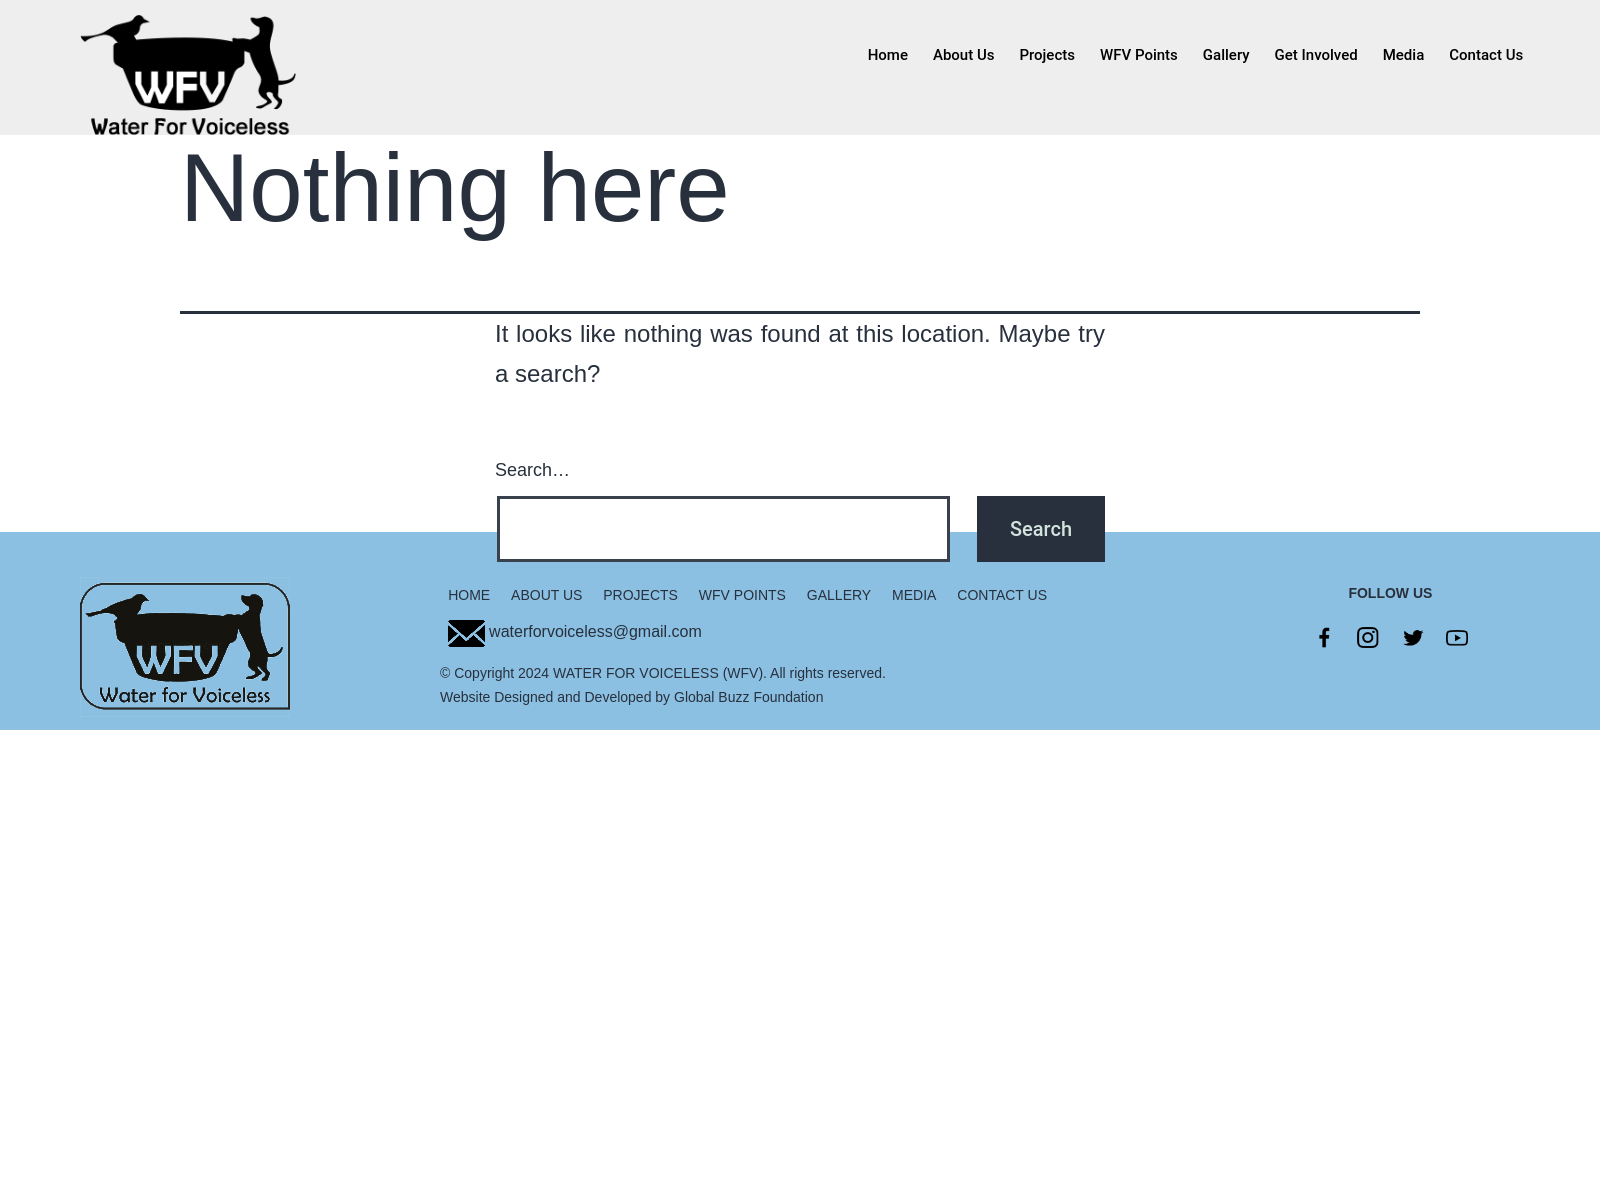

In [25]:
if playbook_results["screenshot"]:
    display(Image(base64.b64decode(playbook_results["screenshot"]), width=240))
else:
    print("No screenshot available.\n\n")

## EN:2 MISP indicators

The next section first **queries MISP for the indicators added to the event** linked to the execution of this playbook. Only those indicators with to_ids set to True are returned (so by default, the associated hostnames from LookyLoo are not returned).

In [26]:
# Get all the indicators for our event and store this is in a table. We can also use this for the summary.
indicator_search = misp.search("attributes", uuid=misp_event.uuid, to_ids=True, pythonify=True)
indicator_raw_list = []
indicator_table = PrettyTable()
if len(indicator_search) > 0:
    indicator_table.field_names = ["Type", "Category", "Indicator", "Comment"]
    indicator_table.align["Type"] = "l"
    indicator_table.align["Category"] = "l"
    indicator_table.align["Indicator"] = "l"
    indicator_table.align["Comment"] = "l"
    indicator_table.border = True
    for indicator in indicator_search:
        if indicator.value not in indicator_raw_list:
            indicator_table.add_row([indicator.type, indicator.category, indicator.value, indicator.comment])
            indicator_raw_list.append(indicator.value)
    print("Got \033[92m{}\033[90m indicator(s) from the event \033[92m{}\033[90m ({}).\n\n".format(len(indicator_raw_list), misp_event.info, misp_event.id))
else:
    print("\033[93mNo indicators found in the event \033[92m{}\033[90m ({})".format(misp_event.info, misp_event.id))

Got 4 indicator(s) from the event URL reputation investigation for https://waterforvoiceless.org/invite.php (3567).




### Raw list of MISP indicators

The indicators are now stored in `indicator_search` (as Python objects) and `indicator_raw_list` (in raw format, only the indicators). Execute the next cell to display them in a table format. The table is also included in the summary sent to Mattermost and TheHive.

In [27]:
if len(indicator_raw_list) > 0:
    print(indicator_table.get_string(sortby="Type"))
    print("\n\nIndicator list in raw format:")
    print("---------------------------------------------------")
    for el in indicator_raw_list:
        print("{}".format(el))
    print("---------------------------------------------------")

+----------+------------------+------------------------------------------+---------------------------------------------------------------------------------+
| Type     | Category         | Indicator                                | Comment                                                                         |
+----------+------------------+------------------------------------------+---------------------------------------------------------------------------------+
| hostname | Network activity | 162-241-169-194.unifiedlayer.com         | https://waterforvoiceless.org/invite.php: Enriched via the urlscan module - PTR |
| hostname | Network activity | waterforvoiceless.org                    |                                                                                 |
| ip-dst   | Network activity | 162.241.169.194                          | https://waterforvoiceless.org/invite.php: Enriched via the urlscan module - IP  |
| url      | Network activity | https://waterforvoiceless.

## EN:3 Create the summary of the playbook

The next section creates a summary and stores the output in the variable `summary` in Markdown format. It also stores an intro text in the variable `intro`. These variables can later be used when sending information to Mattermost or TheHive.

In [28]:
summary = "# MISP Playbook summary\nQuery URL reputation.\n\n"

current_date = datetime.now()
formatted_date = current_date.strftime("%Y-%m-%d")
summary += "## Overview\n\n"
summary += "- Date: **{}**\n".format(formatted_date)
summary += "- URL: **{}**\n".format(playbook_results["url"])
summary += "- LookyLoo submission : {}\n".format(playbook_results["lookyloo"].get("permaurl", ""))
summary += "- URLscan submission : {}\n".format(playbook_results.get("urlscan_resultlink", ""))
summary += "\n\n"
summary += "## URL\n\n"
summary += "- Domain: **{}**\n".format(playbook_results["domain"])
summary += "- Hostname: **{}**\n".format(playbook_results["host"])
item = playbook_results["urlscan"].get("hostname", "")
if len(item) > 0:
    summary += "- Hostname: **{}** (according to URLscan)\n".format(playbook_results["urlscan"].get("hostname", ""))
summary += "- Resolves to: **{}**\n".format(playbook_results["dns"]["resolves"])
summary += "- Resolves to: **{}** (according to URLscan)\n".format(playbook_results["urlscan"].get("ip-dst", ""))
item = playbook_results["urlscan"].get("Page title", "")
if len(item) > 0:
    summary += "- Page title: **{}**\n".format(playbook_results["urlscan"].get("Page title", ""))
item = playbook_results["urlscan"].get("TLS Issuer", "")
if len(item) > 0:
    summary += "- TLS Issuer: **{}**\n".format(playbook_results["urlscan"].get("TLS Issuer", ""))
summary += "- Hosting server: **{}**\n".format(playbook_results["urlscan"].get("Server", ""))
summary += "- IP geolocation: **{}**\n".format(playbook_results["geolocation"])
item = playbook_results["urlscan"].get("geolocation", "")
if len(item) > 0:
    summary += "- ASN country: **{}**\n".format(playbook_results["urlscan"].get("geolocation", ""))
summary += "- Categories: **{}** (according to VirusTotal)\n".format(playbook_results["virustotal"].get("site_categories", ""))
summary += "- Malicious: **{}** (according to VirusTotal)\n".format(playbook_results["virustotal"].get("considered_malicious", ""))
summary += "- Observed hostnames: {} (according to LookyLoo)\n".format(len(playbook_results["lookyloo"]["hostnames"]))
summary += "- Observed cookies: {} (according to LookyLoo)\n".format(len(playbook_results["lookyloo"]["cookies"]))
summary += "- Observed hashes: {} (according to LookyLoo)\n".format(len(playbook_results["lookyloo"]["hashes"]))
summary += "- Observed URLs: {} (according to LookyLoo)\n".format(len(playbook_results["lookyloo"]["urls"]))

summary += "\n\n"
summary += "## LookyLoo\n\n"
summary += "### Related hostnames\n\n"
for hostname in playbook_results["lookyloo"]["hostnames"]:
    summary += "- {}\n".format(hostname)
summary += "\n\n"
summary += "### Cookies\n\n"
for cookie in playbook_results["lookyloo"]["cookies"]:
    summary += "- {}\n".format(cookie["name"])
summary += "\n\n"
summary += "### Related URLs\n\n"
for url in playbook_results["lookyloo"]["urls"]:
    summary += "- {}\n".format(url)
summary += "\n\n"
summary += "### Related hashes\n\n"
for hash in playbook_results["lookyloo"]["hashes"]:
    summary += "- {}\n".format(hash)
summary += "\n\n"
summary += "### Overview table\n\n"
table_lookyloo.set_style(MARKDOWN)
summary += table_lookyloo.get_string()
summary += "\n\n"
summary += "## URLscan\n\n"
summary += "### URLscan - submission results\n\n"
table_urlscan.set_style(MARKDOWN)
summary += table_urlscan.get_string()
summary += "\n\n"
summary += "### URLscan - historical results\n\n"
table_urlscan_history.set_style(MARKDOWN)
summary += table_urlscan_history.get_string()
summary += "\n\n"

summary += "\n\n"
summary += "## VirusTotal\n\n"
table_virustotal.set_style(MARKDOWN)
summary += table_virustotal.get_string()
summary += "\n\n"
                                                                            
summary += "## Indicators\n\n"
summary += "### Indicators table\n\n"
if len(indicator_raw_list) > 0:
    indicator_table.set_style(MARKDOWN)
    summary += indicator_table.get_string(sortby="Type")
    summary += "\n\n\n" 
    summary += "### Indicators in **raw format**\n\n"
    for indicator in indicator_raw_list:
        summary += "{}\n\n".format(indicator)
    summary += "\n" 
else:
    summary += "There are no indicators"
summary += "\n\n"

summary += "## Correlations\n\n"
summary += "### MISP event matches\n\n"
table_mispevents.set_style(MARKDOWN)
summary += table_mispevents.get_string()
summary += "\n\n"

summary += "### MISP feed matches\n\n"
table_mispfeeds.set_style(MARKDOWN)
summary += table_mispfeeds.get_string()
summary += "\n\n"

print("The \033[92msummary\033[90m of the playbook is available.\n\n")

The summary of the playbook is available.




#### Print the summary

In [ ]:
display_markdown(summary, raw=True)

## EN:4 Add the summary as a MISP report

Add the summary as a MISP report to the event.

In [29]:
event_title = "Query URL reputation"
print("Creating MISP report \033[92m{}\033[90m".format(event_title))
chunk_size = 61500
for i in range(0, len(summary), chunk_size):
    chunk = summary[i:i + chunk_size]
    event_report = MISPEventReport()
    event_title_edit = event_title
    if i > 0:
        event_title_edit = "{} ({} > {})".format(event_title, i, i + chunk_size)
    event_report.name = event_title_edit
    event_report.content = chunk
    result = misp.add_event_report(misp_event.id, event_report)
    if "EventReport" in result:
        print(" Report ID: \033[92m{}\033[90m".format(result.get("EventReport", []).get("id", 0)))
    else:
        print("Failed to create report for \033[91m{}\033[90m.".format(event_title))
print("Finished creating report")

Creating MISP report Query URL reputation
 Report ID: 941
Finished creating report


## EN:5 Send a summary to Mattermost

Now you can send the summary to Mattermost. You can send the summary in two ways by selecting one of the options for the variable `send_to_mattermost_option` in the next cell.

- The default option where the entire summary is in the **chat**, or
- a short intro and the summary in a **card**

For this playbook we rely on a webhook in Mattermost. You can add a webhook by choosing the gear icon in Mattermost, then choose Integrations and then **Incoming Webhooks**. Set a channel for the webhook and lock the webhook to this channel with *"Lock to this channel"*.

In [30]:
send_to_mattermost_option = "via a chat message"
#send_to_mattermost_option = "via a chat message with card"

In [31]:
buffer_base64 = playbook_results["screenshot"]
data_url = f"data:image/png;base64,{buffer_base64}"
attachment = [{"fallback": "Screenshot","color": "#ff8000","image_url": data_url}]

message = False

if send_to_mattermost_option == "via a chat message":
    message = {"username": mattermost_playbook_user, "text": summary, "attachments": attachment}
elif send_to_mattermost_option == "via a chat message with card":
    message = {"username": mattermost_playbook_user, "text": intro, "props": {"card": summary}, "attachments": attachment}

if message:
    r = requests.post(mattermost_hook, data=json.dumps(message))
    r.raise_for_status()
if message and r.status_code == 200:
    print("Summary is \033[92msent to Mattermost.\n")
else:
    print("\033[91mFailed to sent summary\033[90m to Mattermost.\n")

Summary is sent to Mattermost.



## EN:6 Send an alert to TheHive

Next to informing your colleagues via Mattermost you can also send an **alert** to TheHive. The alert contains the summary, and a list of indicators as 'observables'.

You can change the alert title with `thehive_alert_title` and provide a reference type with `thehive_alert_reference`. Note that this reference needs to be **unique** in TheHive. If you want to create multiple alerts for the same MISP event then add some random value at the end.

In [32]:
intro = "Playbook query URL reputation"
thehive_alert_title = "MISP Playbook Summary - Query URL reputation"

thehive_alert_reference = "MISP event - {} - {}".format(misp_event.info, misp_event.uuid)
thehive_alert_type = "MISP Playbook alert"
thehive_tlp = 2
thehive_pap = 1

In [33]:
# Code block to send an alert to TheHive
# We use the Python requests library
thehive_headers = {'Content-Type': 'application/json', 'Authorization': f'Bearer {thehive_key}'}
thehive_url_create = "{}/api/v1/alert".format(thehive_url)

thehive_observables = []
for indicator in indicator_search:
    dataType = False
    if indicator.type == "ip-src" or indicator.type == "ip-dst":
        dataType = "ip"
    elif indicator.type == "url":
        dataType = "url"
    elif indicator.type == "hostname":
        dataType = "hostname"        
    elif indicator.type == "email-dst" or indicator.type == "email-src":        
        dataType = "mail"
    if dataType:
        thehive_observables.append({"dataType": dataType, "data": indicator.value, "pap": thehive_pap, "tlp": thehive_tlp})
thehive_alert = {"title": thehive_alert_title, 
                 "description": intro,
                 "summary": summary[0:100000],
                 "type": thehive_alert_type, 
                 "source": "playbook", 
                 "sourceRef": thehive_alert_reference, 
                 "tlp": thehive_tlp, "pap": thehive_pap,
                 "observables": thehive_observables}

result = requests.post(thehive_url_create, headers=thehive_headers, data=json.dumps(thehive_alert))
if result.json()['status'] == 'New':
    thehive_alert_id = result.json()['_id']
    print('The TheHive \033[92malert {} is added'.format(thehive_alert_id))
else:
    print('\033[91mFailed\033[90m to add TheHive alert')
    print(result.text)

The TheHive alert ~651384 is added


## EN:7 Publish MISP event 

As a final step, you can choose the **publish** the MISP event. 

Publishing MISP events makes the event available to your users and, depending on the synchronisation and distribution rules, will also sync it with other connected MISP servers. Publishing an event also typically makes the indicators available for your security controls to import them in their ruleset.

In [34]:
misp.publish(misp_event.uuid)
misp.untag(misp_event.uuid, "workflow:state=\"incomplete\"")
misp.tag(misp_event.uuid, "workflow:state=\"complete\"", True)
print("Event {} ({} - {}) is \033[92mpublished.\n".format(misp_event.info, misp_event.id, misp_event.uuid))

Event URL reputation investigation for https://waterforvoiceless.org/invite.php (3567 - 171b36d9-7a78-44a8-aa16-c7ff65f74b62) is published.



## EN:8 End of the playbook 

In [35]:
print("\033[92m End of the playbook")

 End of the playbook


## External references

- [The MISP Project](https://www.misp-project.org/)
- [Mattermost](https://mattermost.com/)
- [TheHive](https://thehive-project.org/)

## Technical details 

### Documentation

This playbook requires these Python **libraries** to exist in the environment where the playbook is executed. You can install them with `pip install <library>`.

```
PrettyTable
ipywidgets
pylookyloo
pyfaup
```

These **MISP modules** need to be enabled
- urlscan
- dns

### Colour codes

The output from Python displays some text in different colours. These are the colour codes

```
Red = '\033[91m'
Green = '\033[92m'
Blue = '\033[94m'
Cyan = '\033[96m'
White = '\033[97m'
Yellow = '\033[93m'
Magenta = '\033[95m'
Grey = '\033[90m'
Black = '\033[90m'
Default = '\033[99m'
```